In [1]:
import os
import sys
sys.path.insert(0, "..")
import numpy as np
import cv2
import torch
from tqdm import tqdm
from dataset.frames_dataset_with_lmks import FramesDataset
from torch.utils.data import DataLoader
from modulesiris.generator import OcclusionAwareGenerator
import imageio
# Loss
device = 'cuda'

from scipy.spatial.transform import Rotation as R

class GazeAnglePixelMapping():
    def __init__(self, facelmksmodel='data/face68model.txt'):
        self.facelmksmodel = facelmksmodel
        self.points_3d = self.__get_full_model_points(self.facelmksmodel)
        
    def __get_full_model_points(self, filename='data/face68model.txt'):
        """Get all 68 3D model points from file"""
        raw_value = []
        with open(filename) as file:
            for line in file:
                raw_value.append(line)
        model_points = np.array(raw_value, dtype=np.float32) / 10
        model_points = np.reshape(model_points, (3, -1)).T
        p2122 = model_points[33]
        model_points = model_points - p2122

        return model_points
    
    def find_iris_position(self, eyeballcenter, eyecenter, gaze_pitch, gaze_yaw):
        # My = R.from_euler('y', [gaze_yaw], degrees=False).as_matrix()
        # Mx = R.from_euler('x', [gaze_pitch], degrees=False).as_matrix()
        # iris_rotate_y = My@(eyecenter-eyeballcenter) + eyeballcenter
        # iris = Mx@(iris_rotate_y[0]-eyeballcenter) + eyeballcenter
        # return iris[0]

        M = R.from_euler('xy', [gaze_pitch, gaze_yaw], degrees=False).as_matrix()
        # M = R.from_euler('yx', [gaze_yaw, gaze_pitch], degrees=False).as_matrix()
        # print(eyecenter-eyeballcenter, eyeballcenter)
        iris = M@(eyecenter-eyeballcenter) + eyeballcenter
        return iris
        

    def synthesize_iris(self, eyeballcenter, eyecenter, gaze_pitch, gaze_yaw, delta_pitch=-0.2, delta_yaw=0.2):
        new_pitch = gaze_pitch + delta_pitch
        new_yaw = gaze_yaw + delta_yaw
#         print(f'new_pitch :{new_pitch}. New_yaw :{new_yaw}')
        synthesize_iris = self.find_iris_position(eyeballcenter=eyeballcenter, eyecenter=eyecenter, gaze_pitch=new_pitch, gaze_yaw=new_yaw)
        return synthesize_iris
                 
    
    def deltagaze_2_delta_xy(self, lmks2D, fx, fy, cx, cy, gaze, delta_gaze):
        """
        /brief Return delta xy of iris given delta_gaze
        @fx, fy, cx, cy: Intrinsic parameter
        @gaze eyegaze
        @delta_gaze Change ini eyegaze
        """
        # Frontalize face and get the eyegaze in the eyeball coordinate
        camera_matrix = np.array([[fx, 0.0, cx], [0.0, fy, cy], [0.0, 0.0, 1.0]])
        dist_coeffs = np.zeros((4, 1))
        ret, rvec, tvec = cv2.solvePnP(self.points_3d, lmks2D, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_EPNP)
        hR = cv2.Rodrigues(rvec)[0] # rotation matrix
        euler = R.from_matrix(hR).as_euler('xyz', degrees=True)
#         print("euler:",euler)
        ht = tvec[:,0]*10 # cm to mm
#         print(ht)
        
        R_gaze = R.from_euler('xy', gaze, degrees=False).as_matrix() # rotation from gaze to camera
        R_gaze_in_eyeball = hR.T @ R_gaze
        pitch_in_eyeball =  np.arcsin(-R_gaze_in_eyeball[1][2])
        yaw_in_eyeball = np.arcsin(R_gaze_in_eyeball[0][2]/np.cos(pitch_in_eyeball))

        # Caculate eyeball center of leye, reye
        points = self.points_3d.copy()
        c_leye = points[36]/2.0 + points[39]/2.0
        l_eyeball = c_leye.copy()
        l_eyeball[2] = l_eyeball[2] + 12/10 # cm
        
        c_reye = points[42]/2.0 + points[45]/2.0
        r_eyeball = c_reye.copy()
        r_eyeball[2] = r_eyeball[2] + 12/10 # cm
        
        # print(c_leye, c_reye)
        
        # Find position of old iris and new iris for 2 eyes
        left_iris = self.find_iris_position(eyeballcenter=l_eyeball, eyecenter=c_leye, gaze_pitch=pitch_in_eyeball, gaze_yaw=yaw_in_eyeball)
        left_syn_iris = self.synthesize_iris(eyeballcenter=l_eyeball, eyecenter=c_leye, gaze_pitch=pitch_in_eyeball, gaze_yaw=yaw_in_eyeball, delta_pitch=delta_gaze[0], delta_yaw=delta_gaze[1])
        right_iris = self.find_iris_position(eyeballcenter=r_eyeball, eyecenter=c_reye, gaze_pitch=pitch_in_eyeball, gaze_yaw=yaw_in_eyeball)
        right_syn_iris = self.synthesize_iris(eyeballcenter=r_eyeball, eyecenter=c_reye, gaze_pitch=pitch_in_eyeball, gaze_yaw=yaw_in_eyeball, delta_pitch=delta_gaze[0], delta_yaw=delta_gaze[1])
        iris_points = np.array([left_iris, left_syn_iris, right_iris, right_syn_iris])
#         print("iris point: ", iris_points)
#         print("eye center point: ", c_leye, c_reye)

        # print(hR)
        # print(ht)

        # Project to 2d
        camera_matrix = np.array([[fx, 0.0, cx], [0.0, fy, cy], [0.0, 0.0, 1.0]])
        dist_coeffs = np.zeros((4, 1))
        points2d, _ = cv2.projectPoints(iris_points, rvec, tvec, camera_matrix, dist_coeffs)
        points2d = np.reshape(points2d, (-1, 2)) 
        
        delta_xy_left = points2d[1] - points2d[0]
        delta_xy_right = points2d[3] - points2d[2]
        
        return delta_xy_left, delta_xy_right, euler
    
def load_lmks2d(txt):
    with open(txt, 'r') as f:
        lmks = f.readline().split(",")
        lmks = [float(l) for l in lmks]
        lmks = np.reshape(lmks, (-1, 2))
        
        return np.array(lmks)

def lmks2box(lmks, img, expand=1.0):
    xy = np.min(lmks, axis=0).astype(np.int32) 
    zz = np.max(lmks, axis=0).astype(np.int32)

    xy[1] = max(xy[1], 0) 
    wh = zz - xy + 1

    center = (xy + wh/2).astype(np.int32)
    # EXPAND=1.1
    EXPAND=expand
    boxsize = int(np.max(wh)*EXPAND)
    xy = center - boxsize//2
    x1, y1 = xy
    x2, y2 = xy + boxsize
    height, width, _ = img.shape
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(width, x2)
    y2 = min(height, y2)
    return [x1, y1, x2, y2]
def lmks106_to_lmks98(l):
    boundary_and_nose = list(range(0, 55))
    below_nose = list(range(58, 63))
    boundary_left_eye = list(range(66, 74))
    boundary_right_eye = list(range(75, 83))        
    mouth = list(range(84, 104))
    center_left_eye = [104]
    center_right_eye = [105]

    indice = boundary_and_nose + below_nose + boundary_left_eye + boundary_right_eye + mouth + center_left_eye +  center_right_eye
    l = np.array(l)[indice]

    return l

def lmks98_to_lmks68(l):
    LMK98_2_68_MAP = {0: 0,
                    2: 1,
                    4: 2,
                    6: 3,
                    8: 4,
                    10: 5,
                    12: 6,
                    14: 7,
                    16: 8,
                    18: 9,
                    20: 10,
                    22: 11,
                    24: 12,
                    26: 13,
                    28: 14,
                    30: 15,
                    32: 16,
                    33: 17,
                    34: 18,
                    35: 19,
                    36: 20,
                    37: 21,
                    42: 22,
                    43: 23,
                    44: 24,
                    45: 25,
                    46: 26,
                    51: 27,
                    52: 28,
                    53: 29,
                    54: 30,
                    55: 31,
                    56: 32,
                    57: 33,
                    58: 34,
                    59: 35,
                    60: 36,
                    61: 37,
                    63: 38,
                    64: 39,
                    65: 40,
                    67: 41,
                    68: 42,
                    69: 43,
                    71: 44,
                    72: 45,
                    73: 46,
                    75: 47,
                    76: 48,
                    77: 49,
                    78: 50,
                    79: 51,
                    80: 52,
                    81: 53,
                    82: 54,
                    83: 55,
                    84: 56,
                    85: 57,
                    86: 58,
                    87: 59,
                    88: 60,
                    89: 61,
                    90: 62,
                    91: 63,
                    92: 64,
                    93: 65,
                    94: 66,
                    95: 67}

    indice68lmk = np.array(list(LMK98_2_68_MAP.keys()))
    l  = np.array(l)[indice68lmk]

    return l

def lmks106_to_lmks68(l):
    l = lmks106_to_lmks98(l)
    l = lmks98_to_lmks68(l)
    return l

lmks68_2D = load_lmks2d("../devudata/lmks68.txt")
lmks106_2D = load_lmks2d("../devudata/lmks106.txt")
fullframe = cv2.imread("../devudata/img.png")
x1,y1,x2,y2 = lmks2box(lmks68_2D, fullframe,expand=1.2)
face = fullframe[y1:y2, x1:x2]
scale_x = 256.0/(x2-x1)
scale_y = 256.0/(y2-y1)
mapper = GazeAnglePixelMapping(facelmksmodel="../devudata/face68model.txt")
fx=640
fy=640
cx=320
cy=240
gaze = np.array([0.087149,-0.718345])
delta_pitch = 0.2
delta_yaw = 0.2
left_del, right_del, pose = mapper.deltagaze_2_delta_xy(lmks68_2D, fx, fy, cx, cy, gaze, [delta_pitch*3.14/180.0, delta_yaw*3.14/180.0])

In [2]:
root_dir = "../data/eth_motion_data"
augmentation_params = {"flip_param" : {"horizontal_flip": False, "time_flip":False}}

dataset1 = FramesDataset(root_dir, frame_shape=(256, 256, 3), id_sampling=False, is_train=True,
             random_seed=0, pairs_list=None, augmentation_params=augmentation_params)
dataset1.KEYPOINT_INDICES = list(range(106))
dataset1.KEYPOINT_INDICES_WITH_EYELID = list(range(106))
print(len(dataset1))

Use predefined train-test split.
12600


In [6]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tqdm import tqdm

def draw_gaze(image_in, eye_pos, pitchyaw, length=15.0, thickness=2, color=(0, 0, 255)):
    """Draw gaze angle on given image with a given eye positions."""
    image_out = image_in
    if len(image_out.shape) == 2 or image_out.shape[2] == 1:
        image_out = cv2.cvtColor(image_out, cv2.COLOR_GRAY2BGR)
    dx = -length * np.sin(pitchyaw[1])* np.cos(pitchyaw[0])
    dy = length * np.sin(pitchyaw[0])
    cv2.arrowedLine(image_out, tuple(np.round(eye_pos).astype(np.int32)),
                   tuple(np.round([eye_pos[0] + dx, eye_pos[1] + dy]).astype(int)), color,
                   thickness, cv2.LINE_AA, tipLength=0.2)

    return image_out

def draw_landmarks(img, lmks, color=(255,0,0)):
    img = np.ascontiguousarray(img)
    for a in lmks:
        cv2.circle(img,(int(round(a[0])), int(round(a[1]))), 1, color, -1, lineType=cv2.LINE_AA)

    return img

fx = 960
fy = 960
cx=224
cy=224
data = {"left_del_x":[], "left_del_y":[], "right_del_x":[], "right_del_y":[],"len_lefteyelid" :[], "len_righteyelid" :[], "gt_left_del_x": [], "gt_left_del_y": [], "gt_right_del_x": [], "gt_right_del_y": [], "pitch":[], "yaw":[], "roll":[]}
for i in tqdm(range(200)):
    d = dataset1[i]
    im1 = d["source"]
    im1 = (np.transpose(im1, (1,2,0))*255.0).astype(np.uint8)
    im1 = cv2.resize(im1, (448, 448))
    im2 = d["driving"]
    im2 = (np.transpose(im2, (1,2,0))*255.0).astype(np.uint8)
    im2 = cv2.resize(im2, (448, 448))
    lmks1 = d["lmks_source"]["value"]
    lmks2 = d["lmks_driving"]["value"]
    gaze1 = d["gaze_source"]
    gaze2 = d["gaze_driving"]
    lmks1_68 = d["lmks68_source"]
    lmks2_68 = d["lmks68_driving"]
    
    
    lmks1 = (lmks1+1)*448 /2
    left_iris1, right_iris1 = lmks1[104], lmks1[105]
    lmks1 = lmks106_to_lmks68(lmks1)
#     lmks1 = (lmks1_68+1)*448 /2
    lmks2 = (lmks2+1)*448 /2
    left_iris2, right_iris2 = lmks2[104], lmks2[105]
    lmks2 = lmks106_to_lmks68(lmks2)
#     lmks2 = (lmks2_68+1)*448 /2
    

    im1 = draw_landmarks(im1, lmks1)
    im1 = draw_gaze(im1, (224, 100), gaze1, length=65.0, thickness=2, color=(0, 0, 255))
    im3 = np.hstack([im1, im2])
#     plt.imshow(im3)
    
    delta_pitch = (gaze2[0]-gaze1[0])*180.0/3.14
    delta_yaw = (gaze2[1]-gaze1[1])*180.0/3.14
    left_del, right_del, (pitch, yaw, roll) = mapper.deltagaze_2_delta_xy(lmks1, fx, fy, cx, cy, gaze1, [delta_pitch*3.14/180.0, delta_yaw*3.14/180.0])
    
#     pred_left_iris2 = left_iris1 + left_del
#     pred_right_iris2 = right_iris1 + right_del
#     err_left_iris2 = abs(pred_left_iris2-left_iris2)
#     err_right_iris2 = abs(pred_right_iris2-right_iris2) 
    
    left_iris_diff_gt = left_iris2 - left_iris1
    right_iris_diff_gt = right_iris2 - right_iris1
    
    width_leye = np.linalg.norm(lmks1[36] - lmks1[39])
    width_reye = np.linalg.norm(lmks1[42] - lmks1[45])
    data["left_del_x"].append(left_del[0])
    data["left_del_y"].append(left_del[1])
    data["right_del_x"].append(right_del[0])
    data["right_del_y"].append(right_del[1])
    data["len_lefteyelid"].append(width_leye)
    data["len_righteyelid"].append(width_reye)
    data["gt_left_del_x"].append(left_iris_diff_gt[0])
    data["gt_left_del_y"].append(left_iris_diff_gt[1])
    data["gt_right_del_x"].append(right_iris_diff_gt[0])
    data["gt_right_del_y"].append(right_iris_diff_gt[1])
    data["pitch"].append(pitch)
    data["yaw"].append(yaw)
    data["roll"].append(roll)
    
    
    
df = pd.DataFrame(data=data)
df.head(2)

    
#     print("err:", err_left_iris2, err_right_iris2, ". diff gt:", left_iris_diff_gt, ", :", right_iris_diff_gt, ". width leye:",width_leye)
#     break


100%|██████████| 200/200 [00:24<00:00,  8.16it/s]


,left_del_x,left_del_y,right_del_x,right_del_y,len_lefteyelid,len_righteyelid,gt_left_del_x,gt_left_del_y,gt_right_del_x,gt_right_del_y,pitch,yaw,roll
0,12.052558,-4.863243,11.627319,-4.948137,68.894264,81.021202,0.555222,-6.856537,12.528229,-6.779205,-19.450421,4.064099,1.684576
1,0.000000,0.000000,0.000000,0.000000,78.530357,80.796913,0.000000,0.000000,0.000000,0.000000,17.599081,-1.218438,-0.524207


In [140]:
df1 = df.copy()

In [141]:
df = df1[(df1.yaw.abs()<20) &(df1.pitch.abs()<20)]

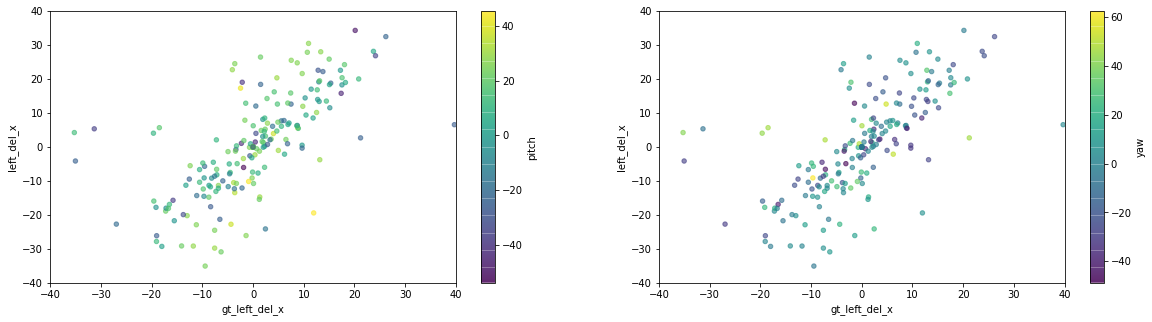

In [7]:
fig, ax = plt.subplots(1,2, figsize=(20, 5))
df.plot.scatter(y='left_del_x', x='gt_left_del_x', c='pitch', colormap='viridis', sharex=False, xlim=[-40,40],  ylim=[-40,40], alpha=0.6, ax=ax[0])
df.plot.scatter(y='left_del_x', x='gt_left_del_x', c='yaw', colormap='viridis', sharex=False, xlim=[-40,40],  ylim=[-40,40], alpha=0.6, ax=ax[1])

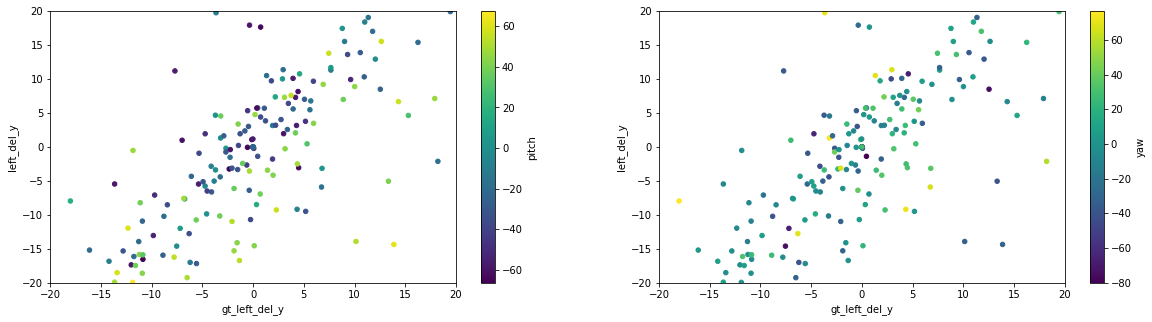

In [5]:
fig, ax = plt.subplots(1,2, figsize=(20, 5))

df.plot.scatter(y='left_del_y', x='gt_left_del_y', c='pitch', colormap='viridis', sharex=False, xlim=[-20,20],  ylim=[-20,20], ax=ax[0])
df.plot.scatter(y='left_del_y', x='gt_left_del_y', c='yaw', colormap='viridis', sharex=False, xlim=[-20,20],  ylim=[-20,20], ax=ax[1])

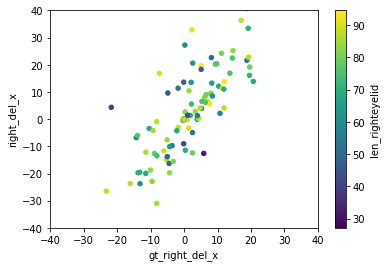

In [104]:
df.plot.scatter(y='right_del_x', x='gt_right_del_x', c='len_righteyelid', colormap='viridis', sharex=False, xlim=[-40,40],  ylim=[-40,40])

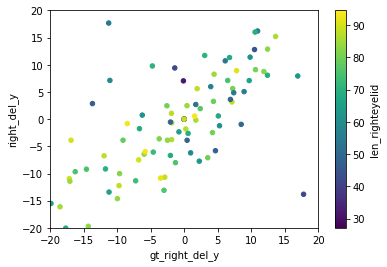

In [105]:
df.plot.scatter(y='right_del_y', x='gt_right_del_y', c='len_righteyelid', colormap='viridis', sharex=False, xlim=[-20,20],  ylim=[-20,20])